# 11. feature selection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
rcParams['figure.figsize'] = (7, 7)
font = {'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
from IPython.core.display import HTML
css_file = '../my.css'
HTML(open(css_file, "r").read())

In machine learning and statistics, feature selection, also known as variable selection, attribute selection or variable subset selection, is the process of selecting the **subset of relevant features** for use in model construction. The central assumption when using a feature selection technique is that the data contains many redundant or irrelevant features. Knowing what feature subset is relevant for the task allows for improved model interpretability, shorter training times and enhanced generalisation by reducing overfitting.

Feature selection is to be distinguished from feature extraction. Feature extraction creates new features from functions of the original features (e.g. PCA), whereas feature selection returns an optimal subset of the features. Feature selection techniques are often used in domains where there are many features and comparatively few samples (or data points). The archetypal case is the use of feature selection in analysing DNA microarrays, where there are many thousands of features, and a few tens to hundreds of samples.

Let's create such a data set. We will generate a train set with 100 samples and 1000 features of which 10 are relevant, 10 are redundant and 980 are irrelevant. We also create a test set with 1000 samples sampled from the same distribution as the train set. Each data set has two classes that can overlap but can be linearly separated:

In [2]:
import sklearn.datasets as datasets
from sklearn.cross_validation import train_test_split

n_train_samples = 100
n_test_samples = 1000
n_features = 1000

(data,targets) = datasets.make_classification(
n_samples=n_train_samples+n_test_samples,
n_features=n_features,
n_classes=2,
n_informative=10,
n_redundant=10,
n_repeated=0,
n_clusters_per_class=2,
random_state=1
)

X, X_test, y, y_test = train_test_split(data, targets, test_size=n_test_samples)



The key idea behind feature selection techniques is simple: define a score $s(F)$ that estimates the relevance of a feature subset $F$ for the task and then find $F$ that optimizes $s(F)$ (for convenience we associate high score $s(F)$ to indicate high relevance of the subset $F$. If there are few features in a data set then one could consider all possible feature subsets to find the best one. However for real world prediction tasks this will not be feasable.

We have seen that greedy algorithms (such as grandient descent) can provide a solution in this case. For instance we can start with the feature subset that contains all the features and iteratively remove features from the subset based on the score $s(F)$ for each resulting feature subset $F$. This is known as **sequential forward selection** and works as follows

1. let $F$ be the subset that contains all the features
2. consider each feature $x_i$ in $F$ and compute the score $s(F_i)$ with $F_i = F \setminus x_i$
3. set $F = F_i$ with $$i = \underset{i}{\operatorname{argmax}}  s(F_i)$$
4. repeat step 3. until the score starts to decrease significantly



Alternatively we can start with the empty feature subset and iteratively add features from the subset based on the score $s(F)$ for each resulting feature subset $F$. This is known as **sequential backward selection** and works as follows

1. let $F$ be an empty set
2. consider each feature $x_i$ not in $F$ and compute the score $s(F_i)$ with $F_i = F \cup x_i$
3. set $F = F_i$ with $$i = \underset{i}{\operatorname{argmax}}  s(F_i)$$
4. repeat step 3. until the score starts to decrease significantly


In feature selection we consider three types of methods: filter, wrapper and embedded methods.

Filter methods compute feature relevance directly from a data set. Typically the relevance of each feature for the task is computed independently from the other features. For instance we can compute the Pearson product-moment correlation coefficient between the feature and the label. High correlation indicates strong relevance to the task of predicting the label. Or we can compute the information gain (as in decision trees) for each feature and use that as an estimate for feature relevance.

Many filters (such as the ones described above) provide a feature ranking rather than an explicit best feature subset. In this case we can apply cross-validation to find a good ranking threshold point to select the best feature subset, as will see further in this chapter. 

A popular feature relevance estimator is the ANOVA F-test (Student's t-test for two classes) that, for a feature $x$, tests if the values for $x$ differ (low $p$-values) for one of the groups. 

To see how this works we create four different features with two classes (green and blue) and use the scikit-learn function *f_classify()* in module *feature_selection* to compute the ANOVA $p$-values for each feature:

C:\Users\user\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


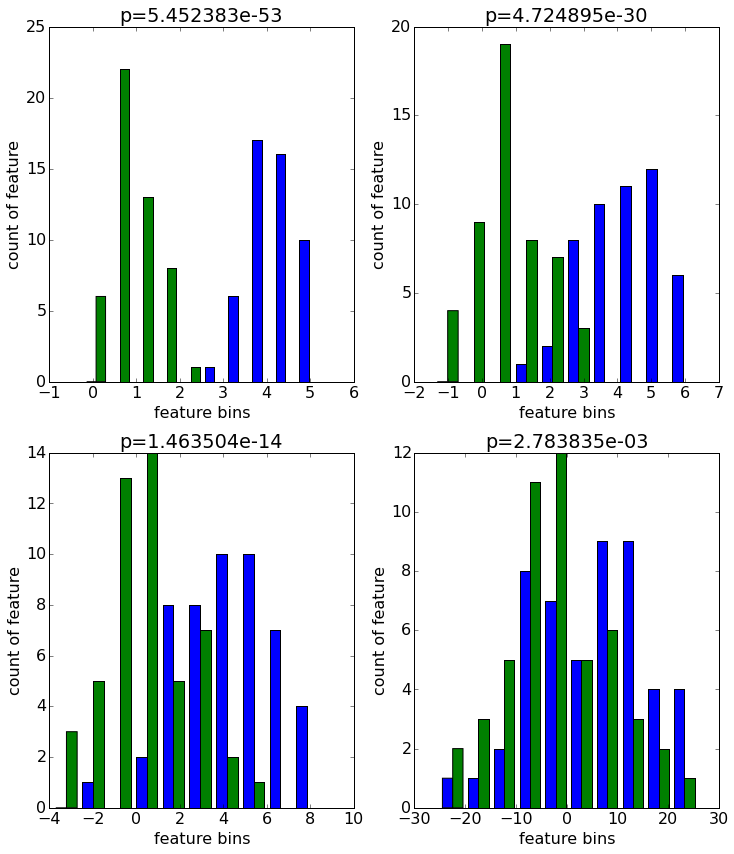

In [3]:
from sklearn import feature_selection

plt.figure(figsize=(12,14))
for i,cluster_std in enumerate([0.5,1,2,10]):
    feature, label = datasets.make_blobs(n_samples=100, n_features=1, centers=2, 
                           cluster_std=cluster_std, shuffle=True, random_state=3)
    (F,pval) = feature_selection.f_classif(feature,label)
    plt.subplot(2,2,i+1)
    plt.hist([feature[label==1],[feature[label==0]]])
    plt.title("p=%e" % pval)
    plt.xlabel('feature bins')
    plt.ylabel('count of feature')
    plt.legend(loc='best')
plt.show()

Notice how features that better discriminate between the classes (i.e. the higly relevant features) show much smaller *p*-values. Usually these $p$-values are transformed into a score $s(x)$ for feature relevance (high score means high relevance) as 

$$s(x)=-\log_{10}p$$

In [4]:
(F,pval) = feature_selection.f_classif(X,y)

pval = -np.log10(pval)

pval_rank = sorted(range(len(pval)), key=lambda k: pval[k],reverse=True)

for i,feature in enumerate(pval_rank):
    if i > 20: break
    print "%i feature %i (%f)" % (i+1,feature,pval[feature])

1 feature 366 (11.227212)
2 feature 981 (8.912935)
3 feature 554 (8.416309)
4 feature 87 (7.144242)
5 feature 493 (3.525281)
6 feature 211 (3.337198)
7 feature 503 (3.210444)
8 feature 264 (2.835953)
9 feature 390 (2.772039)
10 feature 810 (2.464783)
11 feature 97 (2.422835)
12 feature 973 (2.371506)
13 feature 43 (2.369539)
14 feature 325 (2.349086)
15 feature 238 (2.305814)
16 feature 573 (2.300041)
17 feature 583 (2.277873)
18 feature 532 (2.251566)
19 feature 669 (2.183742)
20 feature 652 (2.141660)
21 feature 708 (2.128822)


Filters are usually not computationally intensive, but they produce a feature set which is not tuned to a specific type of predictive model.

Wrapper methods use a predictive model to compute $s(F)$. For instance we could use the validation set accuracy of the model computed with the features in $F$ as $s(F)$. In this case each new subset is used to train a model, which is tested on the validation set. This approach can be very computationally intensive, but usually provides the best performing feature set for that particular type of model.

Instead of using the performance of a model trained on the feature subset we can also look at the model parameters $\theta$. For instance for linear models we know these parameters are weights for the features, i.e. they weigh the constribution of each feature to the decision boundary. We can thus assume that features $x_i$ with low weights $\theta_i$ can be considered less relevand for the task than features with a large weight assigned. We can exploit this idea to construct the following forward sequential feature selection algorithm:

1. let $F$ be the subset that contains all the features
2. compute a linear model using $F$
3. remove the features $x_i$ with the lowest $\theta_i$
4. repeat step 2. and 3. until the performance on a validation starts to decrease significantly

However this algorithm (known as Recursive Feature Elimination (RFE) in literature) also only produces a feature ranking: the last feature that was removed gets rank 1, the feature removed just before that gets rank 2, etc. 

In scikit-learn we can use the *RFE* object in the *feature_selection* module to compute this ranking for our data set:

In [5]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

svc = SVC(kernel="linear",C=1)
rfe = RFE(estimator=svc, step=1,n_features_to_select=1)
rfe.fit(X, y)

ranking_rank = sorted(range(len(rfe.ranking_)), key=lambda k: rfe.ranking_[k])

for i,feature in enumerate(ranking_rank):
    if i > 20: break
    print "%i feature %i (%f)" % (i+1,feature,rfe.ranking_[feature])

1 feature 186 (1.000000)
2 feature 493 (2.000000)
3 feature 264 (3.000000)
4 feature 390 (4.000000)
5 feature 959 (5.000000)
6 feature 981 (6.000000)
7 feature 54 (7.000000)
8 feature 325 (8.000000)
9 feature 661 (9.000000)
10 feature 104 (10.000000)
11 feature 255 (11.000000)
12 feature 554 (12.000000)
13 feature 471 (13.000000)
14 feature 444 (14.000000)
15 feature 416 (15.000000)
16 feature 994 (16.000000)
17 feature 366 (17.000000)
18 feature 94 (18.000000)
19 feature 164 (19.000000)
20 feature 331 (20.000000)
21 feature 544 (21.000000)


So we used a linear SVM (with fixed C=1) to compute the weights $\theta$ that are used by the RFE algorithm. 

We now obtained a ranking of the features. To find a good feature subset from this ranking we can compute the CV-score for an SVM (C=1) for the top $k$ ranked features and search for $k$ with the highest CV-score.

Here we varry $k$ in steps of 5, compute the CV-score for each feature subset and plot these CV-scores:

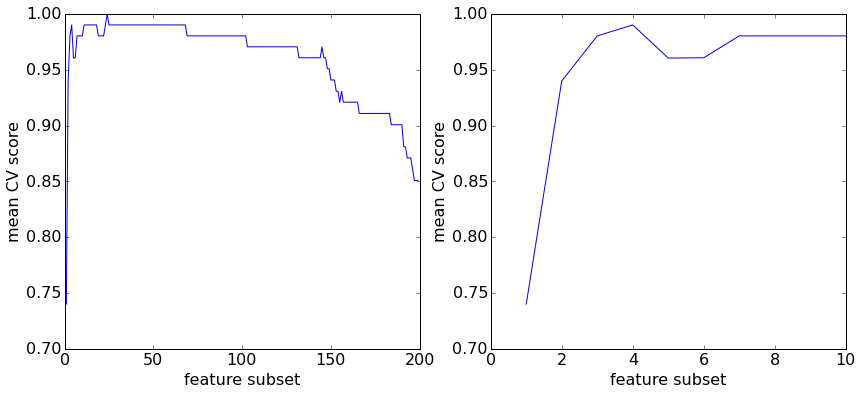

In [16]:
from sklearn import cross_validation

cv_scores = []
feature_subset = []
for k in range(0,n_features-5,5):
    for j in range(k,k+5):
        feature_subset.append(ranking_rank[j])
    cv_scores.append(cross_validation.cross_val_score(svc, X[:,feature_subset], y).mean())

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('feature subset')
plt.ylabel('mean CV score')
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.subplot(1,2,2)
plt.xlabel('feature subset')
plt.ylabel('mean CV score')
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.xlim((0,10))
plt.show()

Tthe plot on the right is a zoom (x-axis) of the plot on the left.

Recall that we created a data set with 10 informative and 10 redundant features. We observe that the CV-score shows a steep increase up to 10 features. However the CV-score is maximum with the top 40 to 50 features in the data set. We also notice that when more irrelevant (random) features are added (>350) the SVC starts to overfit the train sets in the CV iterations.

We can compute the same CV-scores for the ranking produced by the ANOVA F-test:

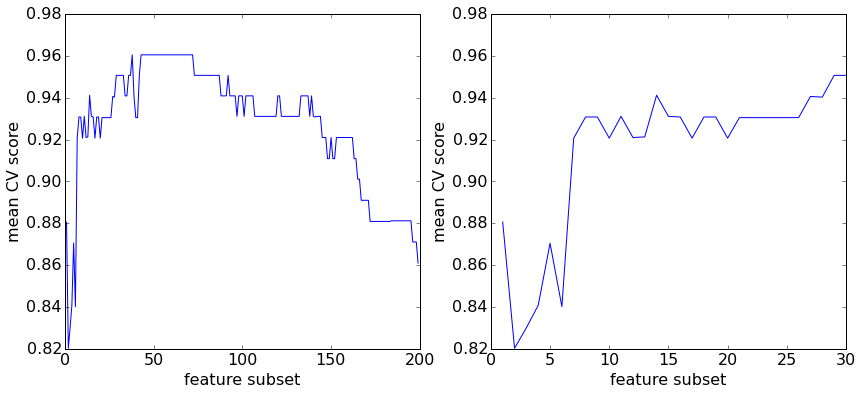

In [17]:
cv_scores = []
feature_subset = []
for k in range(0,n_features-5,5):
    for j in range(k,k+5):
        feature_subset.append(pval_rank[j])
    cv_scores.append(cross_validation.cross_val_score(svc, X[:,feature_subset], y).mean())

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('feature subset')
plt.ylabel('mean CV score')
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.subplot(1,2,2)
plt.xlabel('feature subset')
plt.ylabel('mean CV score')
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.xlim((0,30))
plt.show()

Instead of using CV-scores we can also compute to performance of the different feature subsets on the test set. So we train an SVC (C=1) on the top $k$ ranked features and score this model against the test set. Note that this test set was **not** used for computing the feature ranking.

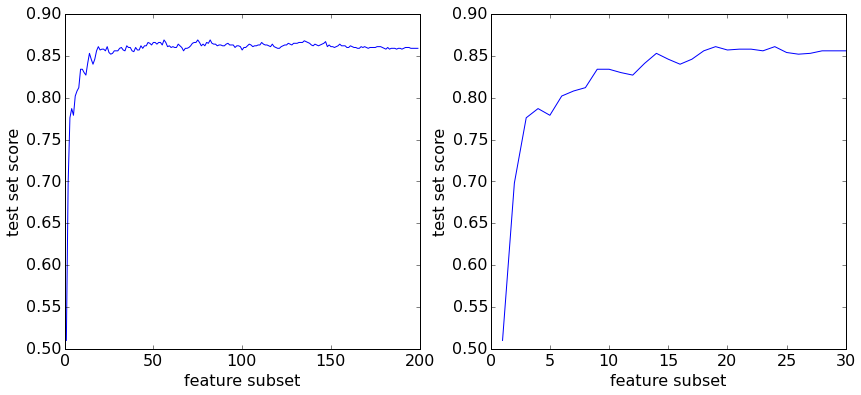

In [18]:
test_scores = []
feature_subset = []
for k in range(0,n_features-5,5):
    for j in range(k,k+5):
        feature_subset.append(ranking_rank[j])
    svc.fit(X[:,feature_subset], y)
    test_scores.append(svc.score(X_test[:,feature_subset],y_test))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('feature subset')
plt.ylabel('test set score')
plt.plot(range(1, len(cv_scores) + 1), test_scores)
plt.subplot(1,2,2)
plt.xlabel('feature subset')
plt.ylabel('test set score')
plt.plot(range(1, len(cv_scores) + 1), test_scores)
plt.xlim((0,30))
plt.show()

In this case we observe a steep increase up to 15 features. When we look at the plot on the left we can see that the performance on the test set still increases significantly afther the top 50 features. 

We can do the same for the ANOVA ranking at see that this performs rather poor:

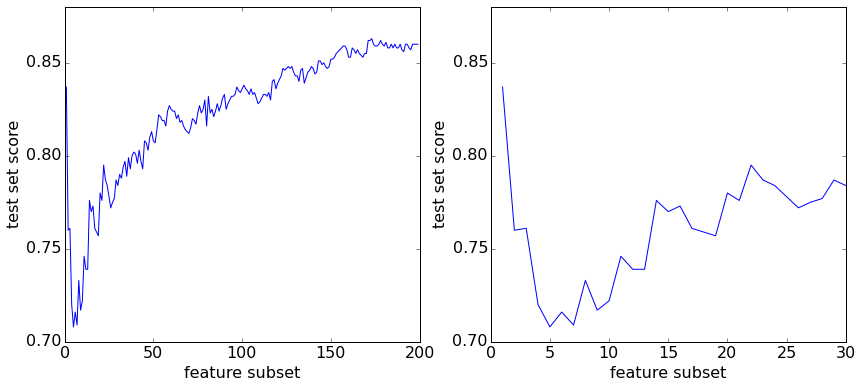

In [25]:
test_scores = []
feature_subset = []
for k in range(0,n_features-5,5):
    for j in range(k,k+5):
        feature_subset.append(pval_rank[j])
    svc.fit(X[:,feature_subset], y)
    test_scores.append(svc.score(X_test[:,feature_subset],y_test))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('feature subset')
plt.ylabel('test set score')
plt.plot(range(1, len(cv_scores) + 1), test_scores)
plt.subplot(1,2,2)
plt.xlabel('feature subset')
plt.ylabel('test set score')
plt.plot(range(1, len(cv_scores) + 1), test_scores)
plt.xlim((0,30))
plt.show()

Embedded methods are a catch-all group of techniques which perform feature selection as part of the model construction process. 

It is clear the the relative rank (i.e. depth) of a feature used as a decision node in a decision tree can be used to assess the relative importance of that feature with respect to the predictability of the target. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features.

For the Random Forests algorithm we can average those expected activity rates over several randomized trees to reduce the variance of such an estimate and use it for feature selection.

The *RandomForestClassifier* object has a property *feature_importances_* that computes these average expected activity rates for the features in the data set: 

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_

importances_rank = sorted(range(len(importances)), key=lambda k: importances[k],reverse=True)

for i,feature in enumerate(importances_rank):
    if i > 20: break
    print "%i feature %i (%f)" % (i+1,feature,importances[feature])


1 feature 366 (0.033713)
2 feature 554 (0.018246)
3 feature 981 (0.016200)
4 feature 87 (0.015202)
5 feature 503 (0.010109)
6 feature 211 (0.007821)
7 feature 325 (0.007240)
8 feature 573 (0.006660)
9 feature 125 (0.006410)
10 feature 97 (0.006197)
11 feature 264 (0.006042)
12 feature 988 (0.005920)
13 feature 812 (0.005785)
14 feature 530 (0.005717)
15 feature 169 (0.005669)
16 feature 332 (0.005075)
17 feature 238 (0.004922)
18 feature 224 (0.004916)
19 feature 583 (0.004893)
20 feature 675 (0.004775)
21 feature 669 (0.004644)


Again we can compute the CV-scores and test set scores for each feature subset as we did above:

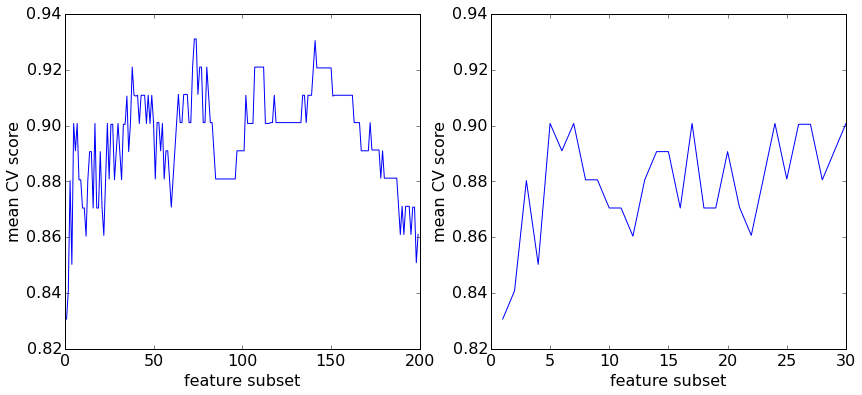

In [20]:
cv_scores = []
feature_subset = []
for k in range(0,n_features-5,5):
    for j in range(k,k+5):
        feature_subset.append(importances_rank[j])
    cv_scores.append(cross_validation.cross_val_score(svc, X[:,feature_subset], y).mean())

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('feature subset')
plt.ylabel('mean CV score')
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.subplot(1,2,2)
plt.xlabel('feature subset')
plt.ylabel('mean CV score')
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.xlim((0,30))
plt.show()

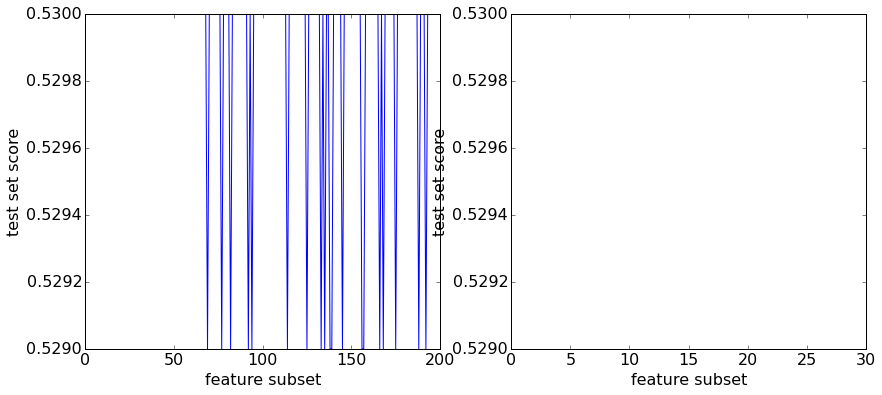

In [21]:
test_scores = []
feature_subset = []
for i in range(0,n_features-5,5):
    for k in range(k,k+5):
        feature_subset.append(importances_rank[j])
    svc.fit(X[:,feature_subset], y)
    test_scores.append(svc.score(X_test[:,feature_subset],y_test))

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('feature subset')
plt.ylabel('test set score')
plt.plot(range(1, len(cv_scores) + 1), test_scores)
plt.subplot(1,2,2)
plt.xlabel('feature subset')
plt.ylabel('test set score')
plt.plot(range(1, len(cv_scores) + 1), test_scores)
plt.xlim((0,30))
plt.show()

Observe how in this case the Random Forest ranking also performs poor on this data set.

<strong>Excersises</strong>

- What is the mean CV accuracy for the best 3 features selected by RFE?

- Create a data set with 1000 samples and 100 features and do the excersise again. Are the conclusions different from those observed for the 100 samples, 1000 features data set?